In [1]:
from pyspark import SparkContext, SparkConf
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = ('--jars /Users/qiyu/Downloads/elasticsearch-hadoop-8.11.3/dist/elasticsearch-spark-20_2.11-8.11.3.jar pyspark-shell')

conf = SparkConf().setAppName("Test").setMaster("local")
sc = SparkContext.getOrCreate(conf=conf)
conf = {
    "es.resource": "kibana_sample_data_ecommerce",
    "es.nodes": "http://localhost",
    "es.port": "9200",
    "es.net.http.auth.user": "elastic",
    "es.net.http.auth.pass": "I_ZriVcfgEw6=3zynBQA",
}
rdd = sc.newAPIHadoopRDD(
    inputFormatClass="org.elasticsearch.hadoop.mr.EsInputFormat",
    keyClass="org.apache.hadoop.io.NullWritable",
    valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable",
    conf=conf
)

23/12/24 18:41:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/24 18:41:13 WARN EsInputFormat: Cannot determine task id...


23/12/24 18:41:27 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [ ]:
# print(rdd.count())
date_id = rdd.map(lambda x: (x[1]["order_date"], x[1]["order_id"])).takeOrdered(10)

print(date_id)

23/12/23 15:52:33 WARN EsInputFormat: Cannot determine task id...


[('2023-12-07T00:04:19+00:00', '550375'), ('2023-12-07T00:08:38+00:00', '550385'), ('2023-12-07T00:23:02+00:00', '550405'), ('2023-12-07T00:33:07+00:00', '550412'), ('2023-12-07T00:47:31+00:00', '550425'), ('2023-12-07T00:50:24+00:00', '728387'), ('2023-12-07T00:54:43+00:00', '550428'), ('2023-12-07T01:16:19+00:00', '550452'), ('2023-12-07T01:27:50+00:00', '550466'), ('2023-12-07T01:32:10+00:00', '550471')]


In [2]:
orders = rdd.map(lambda x: x[1]).cache()
select_order_ids = orders.filter(lambda x: x["customer_id"] == "31").map(lambda x: x["order_id"]).collect()
print(len(select_order_ids))

23/12/24 18:43:32 WARN EsInputFormat: Cannot determine task id...


58


In [3]:
from operator import add
cust_orders = orders.map(lambda x: (x["customer_id"], 1)).reduceByKey(add).sortBy(lambda x: x[1], ascending=False).collect()
print(cust_orders)

[('27', 348), ('52', 188), ('17', 170), ('5', 158), ('20', 154), ('44', 148), ('12', 135), ('42', 135), ('43', 135), ('24', 134), ('45', 134), ('18', 132), ('46', 128), ('26', 122), ('6', 116), ('13', 114), ('22', 111), ('19', 109), ('28', 106), ('25', 101), ('38', 100), ('34', 84), ('48', 80), ('23', 79), ('15', 76), ('11', 75), ('36', 74), ('41', 72), ('14', 72), ('8', 71), ('39', 69), ('9', 69), ('30', 69), ('29', 68), ('49', 67), ('32', 66), ('33', 65), ('16', 65), ('51', 64), ('4', 62), ('7', 59), ('37', 59), ('10', 59), ('50', 58), ('31', 58), ('21', 57)]


<BarContainer object of 46 artists>

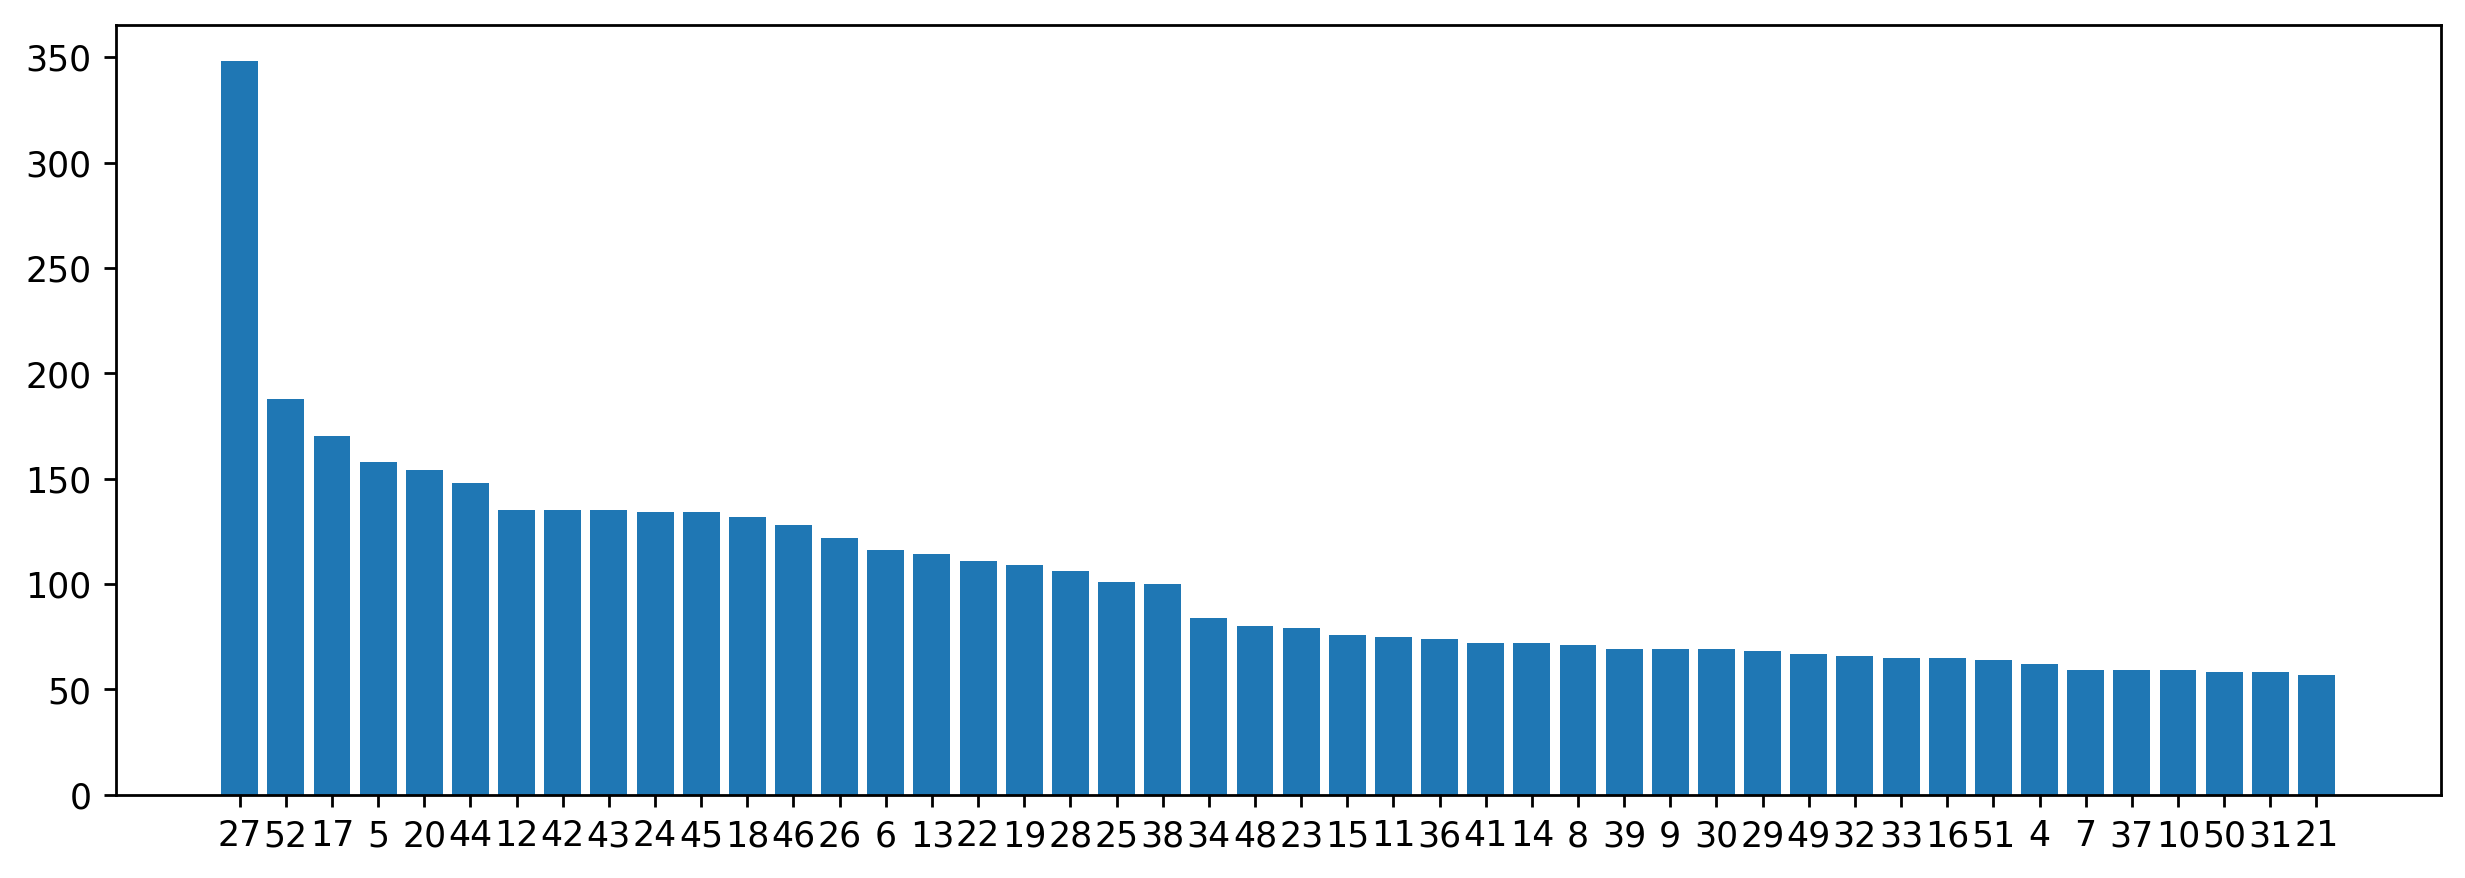

In [16]:
import matplotlib.pyplot as plt
sizes = list()
labels = list()

for item in cust_orders:
    labels.append(item[0])
    sizes.append(item[1])

# plt.pie(sizes, labels=labels, autopct='%1.1f%%')

fig = plt.figure(figsize=(12, 4), dpi=250)
plt.bar(labels, sizes)

In [ ]:
ret = rdd.map(lambda x: x[1]).cache()
rd_name_rdd = ret.map(lambda x: (x["release_date"], x["name"])).groupByKey().cache()
rd_name = rd_name_rdd.mapValues(list).collect()
print(rd_name)

[('1992-06-01', ['Snow Crash']), ('2000-03-15', ['Revelation Space']), ('1985-06-01', ['1984', 'The Handmaids Tale']), ('1953-10-15', ['Fahrenheit 451']), ('1932-06-01', ['Brave New World'])]


23/12/23 01:47:56 WARN EsInputFormat: Cannot determine task id...


In [ ]:
ordered = rd_name_rdd.sortByKey().mapValues(list).collect()
print(ordered)

[('1932-06-01', ['Brave New World']), ('1953-10-15', ['Fahrenheit 451']), ('1985-06-01', ['1984', 'The Handmaids Tale']), ('1992-06-01', ['Snow Crash']), ('2000-03-15', ['Revelation Space'])]


In [ ]:
rd_name = ret.map(lambda x: (x["release_date"], x["name"])).cache()
b1 = rd_name.filter(lambda x: x[0] < "1985-06-01")
# b2 = rd_name.filter(lambda x: x[0] > "1985-06-01")
join_ret = b1.join(rd_name)
print(join_ret.count())
print(b1.rightOuterJoin(rd_name).count())


2
6


In [ ]:
rd_rdd = ret.map(lambda x: x["release_date"]).cache()
print(rd_rdd.takeOrdered(3))

['1932-06-01', '1953-10-15', '1985-06-01']


In [ ]:
print(rd_name.countByKey().items())

dict_items([('1992-06-01', 1), ('2000-03-15', 1), ('1985-06-01', 2), ('1953-10-15', 1), ('1932-06-01', 1)])


[datetime.datetime(1932, 6, 1, 0, 0), datetime.datetime(1953, 10, 15, 0, 0), datetime.datetime(1985, 6, 1, 0, 0), datetime.datetime(1992, 6, 1, 0, 0), datetime.datetime(2000, 3, 15, 0, 0)]
[1, 1, 2, 1, 1]


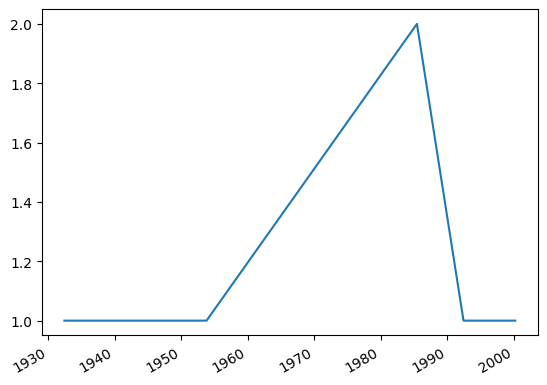

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

def str_to_date(s: str) -> datetime:
    df = "%Y-%m-%d"
    d = datetime.strptime(s, df)
    return d

ordered_rd_name_rdd = rd_name_rdd.sortByKey().mapValues(list).cache()
xs = ordered_rd_name_rdd.map(lambda x: str_to_date(x[0])).collect()
ys = ordered_rd_name_rdd.map(lambda x: len(x[1])).collect()

print(xs)
print(ys)

plt.plot(xs, ys)
plt.gcf().autofmt_xdate()